# Part D: How will things be in 2021
- Going through data for player skill changes, predict the new skill stats for the test set players in
the 2020-21 season
Restrictions :
- Sofifa Id, URL, Wage, Salary, Name, Real face, URL variables cannot be used during the
prediction or learning.

# EDA:

### EDA Goals:
- Pick some features and some players and visualize changes over time. 
- Clean the data and prepare it for modeling. 

In [7]:
# Import needed packages:
import re
import pandas as pd
import numpy as np
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

data_dir = "data\\"
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

<Figure size 432x288 with 0 Axes>

In [8]:
# Take a look at the data:
df2015 = pd.read_csv(data_dir + "players_20.csv")
display(df2015.head())

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


### Data Cleaning:

Looking at the data, we see that some columns, such as skill attributes and position attributes, are stored as strings in the form of "number+margin" or "number-margin". We want to clean these up to only keep the main number and store it as a numerical value.

### Missing Data:
Some data are missing from the dataset. Looking into this, we can see that some skill attributes are missing for goalkeepers and some goalkeeping skills are missing for other players. To fix this, we think that we can replace these missing attributes by a constant that equals to 30. This is a rough estimate of the ability of a player to play as a goalkeeper or the reverse inside the game. This low value represtents players having a low goalkeeping skills and the other way around. We think this way of filling should be enough for our tasks. 

In [9]:
# Function clean_cell_value:
    # Function to apply to every string cell that should be turned into numerical. 
    # Given a string s of the form number+/-number, return the first number as an integer. 
def clean_cell_value(s):
    
    # Missing values:
    if pd.isnull(s):
        return 30
    
    # Already numerical values:
    if type(s) is not str:
        return s
    
    if '-' in s:
        return int(s.split('-')[0])
    if '+' in s:
        return int(s.split('+')[0])
    return int(s)

# Function clean data strings
    # Given a dataframe of data from Fifa, turn all data that should be numerical into numerical data. 
    # Convert from strings if needed. 
def clean_data_strings(df):
    df_cleaned = df.copy()
    numerical_columns = ["age","height_cm","weight_kg","overall","potential","value_eur",
                        "international_reputation","weak_foot","skill_moves","release_clause_eur","contract_valid_until", 
                        "nation_jersey_number","pace","shooting","passing","dribbling","defending","physic","gk_diving",
                        "gk_handling","gk_kicking","gk_reflexes","gk_speed","gk_positioning","attacking_crossing",
                        "attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
                        "attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy","skill_long_passing",
                        "skill_ball_control","movement_acceleration","movement_sprint_speed","movement_agility",
                        "movement_reactions","movement_balance","power_shot_power","power_jumping","power_stamina",
                        "power_strength","power_long_shots","mentality_aggression","mentality_interceptions",
                        "mentality_positioning","mentality_vision","mentality_penalties","mentality_composure",
                        "defending_marking","defending_standing_tackle","defending_sliding_tackle","goalkeeping_diving",
                         "goalkeeping_handling","goalkeeping_kicking","goalkeeping_positioning","goalkeeping_reflexes",
                        "ls","st","rs","lw","lf","cf","rf","rw","lam","cam","ram","lm","lcm","cm","rcm","rm","lwb","ldm",
                         "cdm","rdm","rwb","lb","lcb","cb","rcb","rb" ]
    for col in numerical_columns:
        df_cleaned[col] = df_cleaned[col].apply(clean_cell_value)
    return df_cleaned

# Check the results:
df2015 = clean_data_strings(df2015)
print(df2015.dtypes)

sofifa_id      int64
player_url    object
short_name    object
long_name     object
age            int64
               ...  
lb             int64
lcb            int64
cb             int64
rcb            int64
rb             int64
Length: 104, dtype: object


### Merge by Player:

There are different ways to merge the data. We can merge by player, so that in the result, we will have one player per row, and the row would have all the data for the player from all years. We can also consider each tansition for a player from one year to the next one as a row. Right now, we will take the first approach to do some visualizations. Later, we will discuss the second approach. 

In [4]:
# Function merged_data (merge_type):
    # Read the data from different years, merge them with how=merge_type, and return the resulting dataframe
    # This function merges by players. The resulting dataframe has one row per player.
def merge_data_over_years(merge_type="inner"):
    
    columns_to_drop = ["player_url", "wage_eur", "real_face", "long_name", "short_name"]

    # Initial data frame:
    df = pd.read_csv(data_dir + "players_15.csv").drop(columns_to_drop, axis=1)
    predictors = df.columns
    df = clean_data_strings(df)
    predictors_2015 = {x:x+"_2015" for x in predictors}
    predictors_2015["sofifa_id"]="sofifa_id"
    df = df.rename(columns=predictors_2015)

    # Merging with the other dataframs:
    years = ["16", "17", "18", "19", "20"]
    for year in years:
        # Read the data:
        df_new = pd.read_csv(data_dir + "players_"+year+".csv")

        # Rename the columns:
        df_new = df_new.drop(columns_to_drop, axis=1)
        df_new = clean_data_strings(df_new)
        cur_predictors = {x:x+"_20"+year for x in predictors}
        cur_predictors["sofifa_id"]="sofifa_id"
        df_new = df_new.rename(columns=cur_predictors)

        # Merge with df:
        df = df.merge(df_new, on="sofifa_id", how="inner")
    return df

In [5]:
# Check the result:
df = merge_data_over_years()
print(f"The shape of the resulting data frame is {df.shape}")
display(df.head())

The shape of the resulting data frame is (4762, 589)


,sofifa_id,age_2015,dob_2015,height_cm_2015,weight_kg_2015,nationality_2015,club_2015,overall_2015,potential_2015,value_eur_2015,...,lwb_2020,ldm_2020,cdm_2020,rdm_2020,rwb_2020,lb_2020,lcb_2020,cb_2020,rcb_2020,rb_2020
0,158023,27,1987-06-24,169,67,Argentina,FC Barcelona,93,95,0,...,68,66,66,66,68,63,52,52,52,63
1,20801,29,1985-02-05,185,80,Portugal,Real Madrid,92,92,0,...,65,61,61,61,65,61,53,53,53,61
2,41236,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,90,0,...,53,57,57,57,53,50,52,52,52,50
3,167495,28,1986-03-27,193,92,Germany,FC Bayern München,90,90,0,...,30,30,30,30,30,30,30,30,30,30
4,176580,27,1987-01-24,181,81,Uruguay,FC Barcelona,89,91,0,...,67,67,67,67,67,64,63,63,63,64


Note that we only have 4762 rows now. This is because many players are not present in all 5 years. This is fine for visualizations, but we might consider an outer merge for later analyses. 


### Initial Visualizations:

We move on to some initial visualizations. There are a lot of response variables and a lot of data points, so, let's choose a subset of them and visualize the subset. First, let's choose some skills and a subset of players and see how the skills are changing in the given time period. 

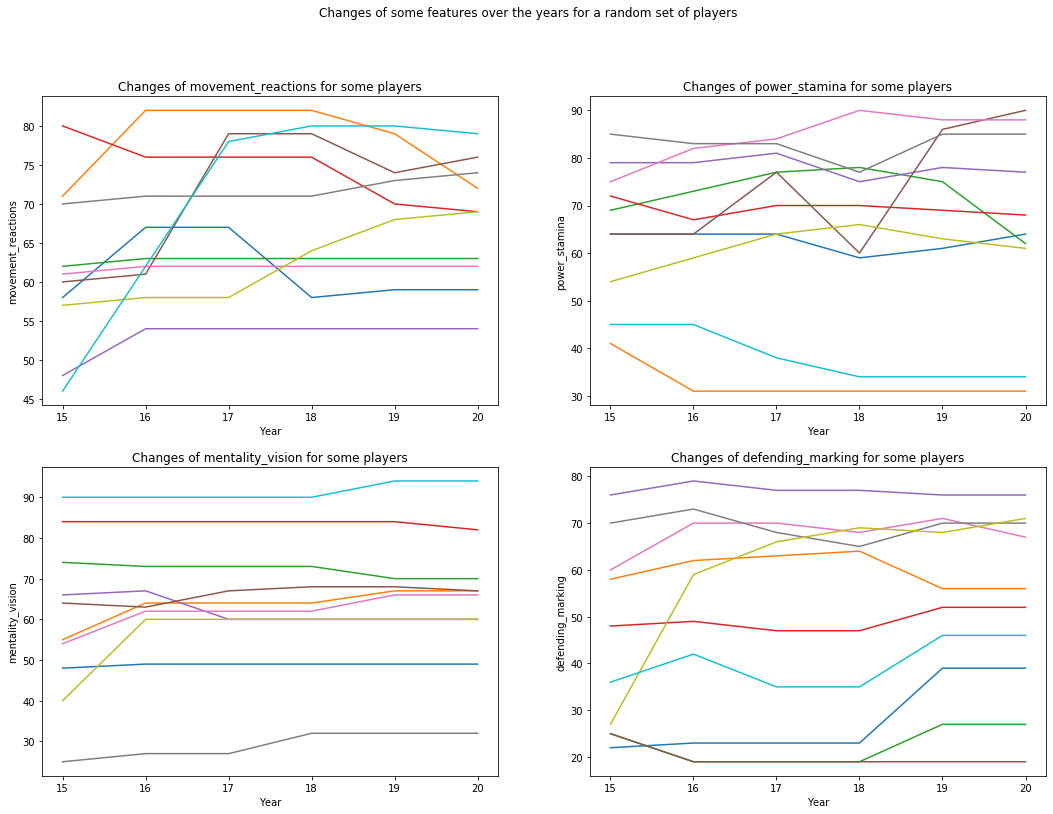

In [6]:
# Choose some features for plotting: 
features = [ 'movement_reactions', 'power_stamina', 'mentality_vision', 'defending_marking']

years = ["15", "16", "17", "18", "19", "20"]
random_state = 10

fig, axs = plt.subplots(nrows=2,ncols=2)
fig.suptitle("Changes of some features over the years for a random set of players")
fig.set_size_inches(18, 12.5)
for i in range(len(features)):
    feature = features[i]
    y_columns = [feature+'_20'+year for year in years]
    
    # Choose some players, change the random state so we don't plot the same players every time:
    df_new = df[y_columns].sample(n = 10, random_state = random_state)
    random_state += 1
    
    # Plot:
    cur_ax = axs[i//2][i%2]
    for ind in range(len(df_new)):
        cur_ax.plot(years, df_new.iloc[ind], label=f"Player {str(ind)}")
    cur_ax.set_title(f"Changes of {feature} for some players")
    cur_ax.set_xlabel("Year")
    cur_ax.set_ylabel(f"{feature}")

We can see that these skills change a little from year to year, with some players having big jumps from time to time. However, we note that the changes in the values are small compared to the overall values. The values change about 5-10 from year to year, which is small compared to the overall values that range from 60 to 90. If we try to predict the overall values from year to year, our models will waste a lot of work predicting the overall values and they might consider the small changes as noise.

For example, let's look at scatter plots of some attributes in 2016 vs these attributes in 2015.

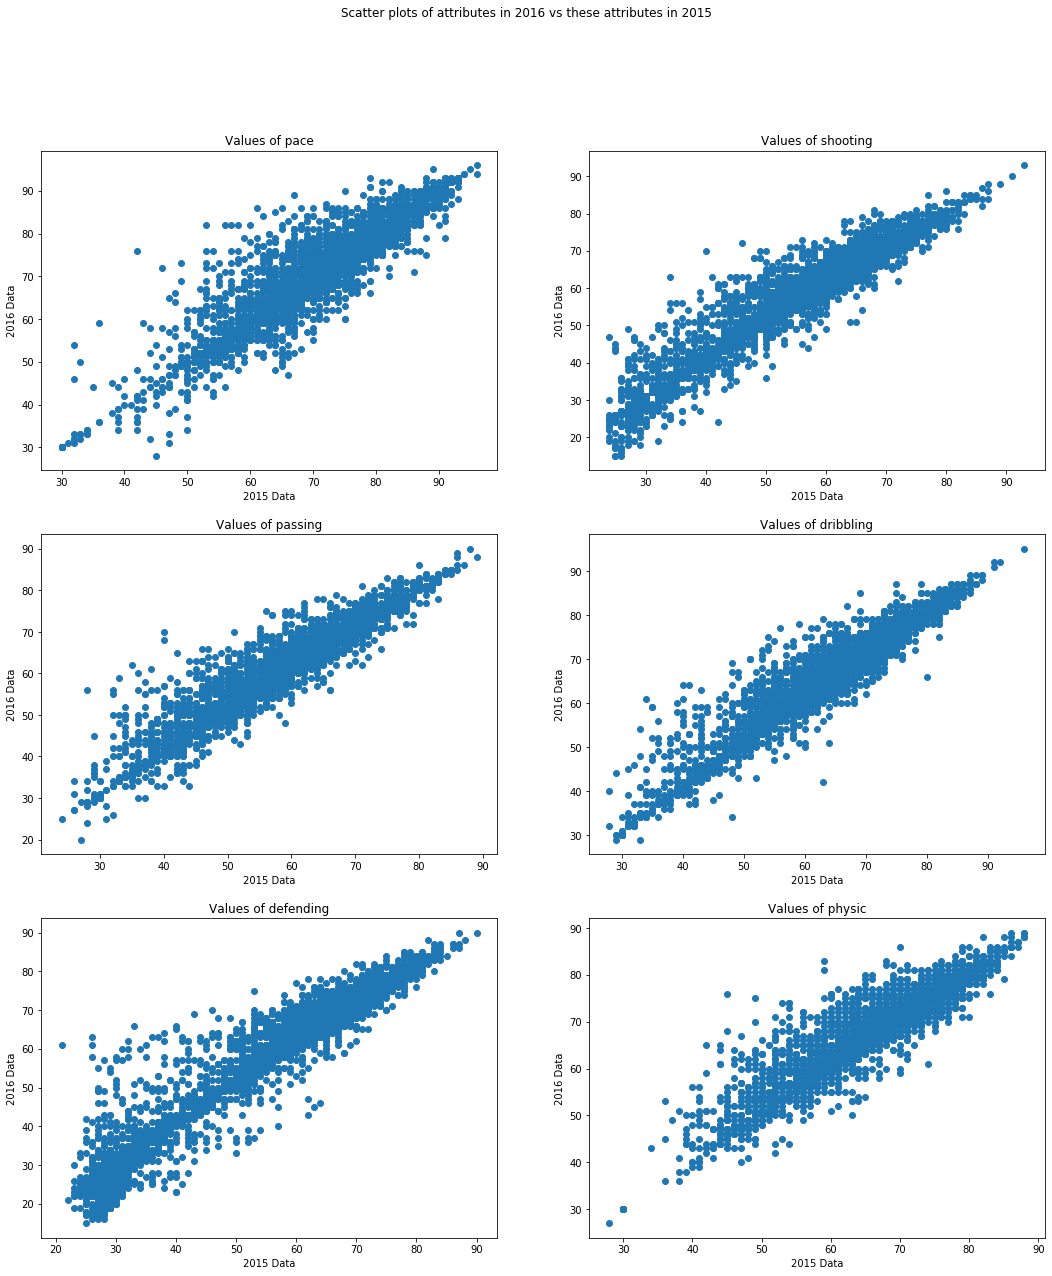

In [7]:
features = [ "pace", "shooting", "passing", "dribbling", "defending", "physic"]
fig, axs = plt.subplots(nrows=3,ncols=2)
fig.suptitle("Scatter plots of attributes in 2016 vs these attributes in 2015")
fig.set_size_inches(18, 20)
for i in range(len(features)):
    feature = features[i]
    cur_ax = axs[i//2][i%2]
    cur_ax.scatter(df[feature+"_2015"], df[feature+"_2016"])
    cur_ax.set_title(f"Values of {feature}")
    cur_ax.set_xlabel("2015 Data")
    cur_ax.set_ylabel("2016 Data")

We can see that there is a near perfect linear correlation. Simple models might consider the small changes as noise. Instead, we can consider only predicting the changes. For example, let's look at the changes is the "physic" skill vs the age.

,sofifa_id,age_2015,dob_2015,height_cm_2015,weight_kg_2015,nationality_2015,club_2015,overall_2015,potential_2015,value_eur_2015,...,lwb_2020,ldm_2020,cdm_2020,rdm_2020,rwb_2020,lb_2020,lcb_2020,cb_2020,rcb_2020,rb_2020
0,158023,27,1987-06-24,169,67,Argentina,FC Barcelona,93,95,0,...,68,66,66,66,68,63,52,52,52,63
1,20801,29,1985-02-05,185,80,Portugal,Real Madrid,92,92,0,...,65,61,61,61,65,61,53,53,53,61
2,41236,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,90,0,...,53,57,57,57,53,50,52,52,52,50
3,167495,28,1986-03-27,193,92,Germany,FC Bayern München,90,90,0,...,30,30,30,30,30,30,30,30,30,30
4,176580,27,1987-01-24,181,81,Uruguay,FC Barcelona,89,91,0,...,67,67,67,67,67,64,63,63,63,64


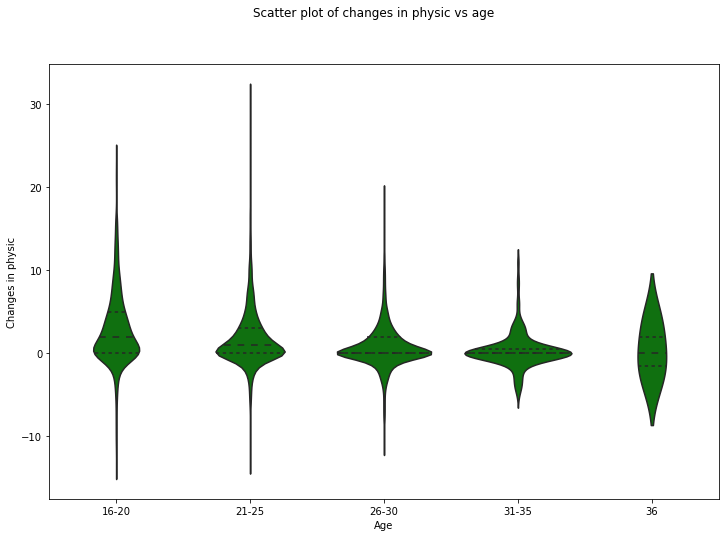

In [8]:
display(df.head())
# Select the data:
feature = 'physic'

x_plot = df["age_2015"].values
x_plot_cat = (x_plot-16)//5
names_of_categories = ["16-20", "21-25", "26-30", "31-35", "36"]
x_plot_cat = np.array(names_of_categories)[x_plot_cat]


y_first_year = df[f"{feature}_2015"].values
y_second_year = df[f"{feature}_2016"].values
y_plot = y_second_year - y_first_year

# Create the plot:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
fig.suptitle("Scatter plot of changes in physic vs age")
ax.set_xlabel(f"Age")
ax.set_ylabel(f"Changes in {feature}")

# Plot:
sns.violinplot(x=x_plot_cat,y=y_plot, color="green", ax=ax, inner="quartile", order=names_of_categories)
#ax.hlines(y=0, xmin = 0, xmax = 4, color = "red")

We can see that young players, with ages 16-25, have a 25th percentile of change of 0, while older players of ages 26-36 have a mean change of 0. As players get older, they are less likely to have high increases in physical power. 

### More Data Cleaning:

We decided that to predict the year 2021, we use the same data as 2020 and then add expected changes. This approach has multiple benefits
- As mentioned previously, it takes full advantage of the fact that the changes are small and that it's better to predict the changes rather than the full values in each year.
- This allows for a much bigger size of data. Every data point would be a player's transtion between years. This also makes better use of data for players who aren't present in all five years.
- Some data rarely changes from year to year. Player's nationality and favorite foot never change, and their positions and club rarely change. We will later go over the columns more and check take a look at each column and whether it is useful for predictions and whether it's interesting to study its changes. 

Now let's look at each column. We divide the columns to three groups:
#### Group 1: 
Columns that we will neither predict nor use as predictors. These are the columns we think aren't useful for predicting changes and they don't change from year to year or aren't very interesting to predict. This includes the columns:

['sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 'weight_kg', 'nationality', 'value_eur', 'wage_eur', 'player_positions','preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_jersey_number', 'joined', 'nation_position', 'nation_jersey_number', 'player_traits']

#### Group 2: 
Columns that are useful as predictors, possibly after some changes/transformations. These are columns that we don't expect to change from year to year but affect how the rest of the values change. This also includes the column 'age' that changes from year to year but isn't interesting to predict because the change is always 1. This group right now also includes the club. We won't use the club in any predictions but we want to keep it in the data so we can later split the train and test data based on clubs. This group includes the columns:

['age', "potential", 'height_cm', 'club', 'team_position', 'loaned_from', 'contract_valid_until']

#### Group 3: 
The rest of the columns. These are numberical columns that we want to study their changes from year to year. We also expect each column to only be interesting to predict its own changes. For example, the overall 'defending' in one year can help predict the change in 'defending' to the next year, but it wouldn't affect the changes of the 'dribbling' for example. However, for now, we will use the overall values of all of this group to predict its changes. This group includes:

["overall", "pace","shooting","passing","dribbling","defending","physic","gk_diving",
"gk_handling","gk_kicking","gk_reflexes","gk_speed","gk_positioning","attacking_crossing",
"attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
"attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy","skill_long_passing",
"skill_ball_control","movement_acceleration","movement_sprint_speed","movement_agility",
"movement_reactions","movement_balance","power_shot_power","power_jumping","power_stamina",
"power_strength","power_long_shots","mentality_aggression","mentality_interceptions",
"mentality_positioning","mentality_vision","mentality_penalties","mentality_composure",
"defending_marking","defending_standing_tackle","defending_sliding_tackle","goalkeeping_diving",
 "goalkeeping_handling","goalkeeping_kicking","goalkeeping_positioning","goalkeeping_reflexes",
"ls","st","rs","lw","lf","cf","rf","rw","lam","cam","ram","lm","lcm","cm","rcm","rm","lwb","ldm",
 "cdm","rdm","rwb","lb","lcb","cb","rcb","rb"]

In [10]:
Group1 = ['sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 'weight_kg', 'nationality', 'value_eur', 
          'wage_eur', 'player_positions','preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 
          'real_face', 'release_clause_eur', 'player_tags', 'team_jersey_number', 'joined', 'nation_position', 'nation_jersey_number', 
          'player_traits']

Group2 = ['age', 'potential', 'height_cm', 'club', 'team_position', 'loaned_from', 'contract_valid_until']

Group3 = ["overall", "pace","shooting","passing","dribbling","defending","physic","gk_diving",
          "gk_handling","gk_kicking","gk_reflexes","gk_speed","gk_positioning","attacking_crossing",
          "attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
          "attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy","skill_long_passing",
          "skill_ball_control","movement_acceleration","movement_sprint_speed","movement_agility",
          "movement_reactions","movement_balance","power_shot_power","power_jumping","power_stamina",
          "power_strength","power_long_shots","mentality_aggression","mentality_interceptions",
          "mentality_positioning","mentality_vision","mentality_penalties","mentality_composure",
          "defending_marking","defending_standing_tackle","defending_sliding_tackle","goalkeeping_diving",
          "goalkeeping_handling","goalkeeping_kicking","goalkeeping_positioning","goalkeeping_reflexes",
          "ls","st","rs","lw","lf","cf","rf","rw","lam","cam","ram","lm","lcm","cm","rcm","rm","lwb","ldm",
          "cdm","rdm","rwb","lb","lcb","cb","rcb","rb"]

In [11]:
# Function clean_data_change_columns:
    # Given two data frames for consecutive years, create the data for the first year predictors 
    # and the first year to second year changes.
    # This function should also apply the previous cleaning function that cleans strings from the numerical data

def clean_data_change_columns(df_cur_year, df_next_year):
    
    df_cur_year = df_cur_year.copy()
    df_next_year = df_next_year.copy()
    
    # Remove players who aren't in both years:
    player_ids = df_cur_year['sofifa_id'].values
    player_ids_bool = [ (x in df_next_year['sofifa_id'].values) for x in player_ids ]
    player_ids = player_ids[ player_ids_bool ]
    df_cur_year = df_cur_year.loc[ df_cur_year['sofifa_id'].isin(player_ids) ].sort_values(by='sofifa_id')
    df_cur_year = df_cur_year.reset_index(drop=True)
    df_next_year = df_next_year.loc[ df_next_year['sofifa_id'].isin(player_ids) ].sort_values(by='sofifa_id')
    df_next_year = df_next_year.reset_index(drop=True)
    
    # Clean the strings and drop extra columns:
    df_cur_year = clean_data_strings(df_cur_year).drop(Group1, axis = 1)
    
    df_next_year = clean_data_strings(df_next_year).drop(Group1, axis = 1)
    df_next_year = df_next_year.drop(Group2, axis = 1)

    
    # Create the columns for changes:
    Group3_changes = [ f"Change in {x}" for x in Group3 ]
    df_cur_year[Group3_changes] = df_next_year[Group3] - df_cur_year[Group3]

    return df_cur_year

# Check the result:
df2015 = pd.read_csv(data_dir + "players_15.csv")
df2016 = pd.read_csv(data_dir + "players_16.csv")
df_check = clean_data_change_columns(df2015, df2016)
display(df_check.head())

,age,height_cm,club,overall,potential,team_position,loaned_from,contract_valid_until,pace,shooting,...,Change in lwb,Change in ldm,Change in cdm,Change in rdm,Change in rwb,Change in lb,Change in lcb,Change in cb,Change in rcb,Change in rb
0,32,181,Udinese,68,68,LM,NaN,2016.0,71.0,59.0,...,1,2,2,2,1,0,1,1,1,0
1,33,175,LA Galaxy,79,79,RS,NaN,2016.0,68.0,81.0,...,0,-3,-3,-3,0,1,-1,-1,-1,1
2,38,188,Stevenage,59,59,SUB,NaN,2015.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,0
3,31,171,Nottingham Forest,71,71,SUB,NaN,2016.0,38.0,63.0,...,-6,-3,-3,-3,-6,-5,-1,-1,-1,-5
4,41,194,Chelsea,76,76,SUB,NaN,2015.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,0


Now we take another look into some of the predictors from group 2. 

Group2 = ['age', "potential", 'height_cm', 'team_position', 'loaned_from', 'joined', 'contract_valid_until']

#### Potential:
We don't expect the potential itself to be giving a lot of information. However, we expect that potential minus overall can be a very good predictor. If a player has a potential a lot higher than the overall score, then we would predict his attributes to increase a lot. But if they are equal, we wouldn't predict the attributes to increase a lot. So, instead of the potential, we store the difference between potential and overall.

#### Team Position:
This is a categorical variable. So, we should create dummy variables for its different categories. 

#### Loaned From:
We don't think where the player has been loaned from is of big importance. However, the fact that a player has been loaned can be useful. Usually, players are loaned so they can play more and gain more experience. So, this can predict improvements over time. 

#### Contract Valid Until:
How long is a player's contract doesn't seem like very useful data. However, the fact that a player has only has one year left in the contract can be a good predictor. When a player only has one year left in the contract, he might work harder to get better contracts or move to better clubs. So, instead of storing the contract years, we store binary variables for whether the player only has one year left in the contract. 

In [12]:
# Function clean_data_group_2:
    # Given a data frame of fifa data, change the columns of group 2 so that they are more useful
def clean_data_group_2(df, year):
    df = df.copy()
    
    df['potential'] = df['potential'] - df['overall']
    
    df = pd.get_dummies( df, columns = ['team_position'], prefix = 'position' )
    
    df['loaned_from'] = df['loaned_from'].fillna('no_club')
    df['loaned_from'] = 1-(df['loaned_from']=='no_club')
    
    df['contract_valid_until'] = df['contract_valid_until'].fillna(2025)
    df['contract_valid_until'] = (df['contract_valid_until']==year+1)
    
    return df

# Check the results:
display(clean_data_group_2(df_check, 2015).head())

,age,height_cm,club,overall,potential,loaned_from,contract_valid_until,pace,shooting,passing,...,position_RCM,position_RDM,position_RES,position_RF,position_RM,position_RS,position_RW,position_RWB,position_ST,position_SUB
0,32,181,Udinese,68,0,0,True,71.0,59.0,66.0,...,0,0,0,0,0,0,0,0,0,0
1,33,175,LA Galaxy,79,0,0,True,68.0,81.0,73.0,...,0,0,0,0,0,1,0,0,0,0
2,38,188,Stevenage,59,0,0,False,30.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,1
3,31,171,Nottingham Forest,71,0,0,True,38.0,63.0,75.0,...,0,0,0,0,0,0,0,0,0,1
4,41,194,Chelsea,76,0,0,False,30.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,1


### Merging the Data Points:

Now, we are ready to treat the data as transitions and merge all the years together:

In [13]:
# Function aggregate_data (merge_type):
    # Read the data from different years, find the transition data and combine them in one data frame and return it.
def aggregate_data():
    
    # Initial data frames:
    cur_df = pd.read_csv(data_dir + "players_15.csv")
    new_df = pd.read_csv(data_dir + "players_16.csv")
    df = clean_data_change_columns(cur_df, new_df)
    df = clean_data_group_2(df, 2015)

    # Merging with the other dataframs:
    years = [16, 17, 18, 19]
    for year in years:
        # Read the data:
        cur_df = pd.read_csv(data_dir + "players_"+str(year)+".csv")
        new_df = pd.read_csv(data_dir + "players_"+str(year+1)+".csv")

        # Clean the data and merge it:
        df_to_push = clean_data_change_columns(cur_df, new_df)
        df_to_push = clean_data_group_2(df_to_push, 2000+year)
        df = df.append(df_to_push)
    return df

In [14]:
df = aggregate_data()

In [15]:
print(f"The shape of the resulting data frame is {df.shape}")

The shape of the resulting data frame is (59399, 181)


We believe that the resulting dataframe is ready for modeling. From now on, we will only use this data frame. 

### Insight on the Response Variables:

In this part of the project, we have 73 different response variables. This can make the problem really hard. We don't want to do individual modeling for every single response variable. Luckily, we can group some of our response variables together. There are three clear groups that we can make and then an additional "miscellaneous" group. For the first three groups, we believe that these numbers were chosen in similar ways when creating the FIFA game, and so, we expect models to preform similarly on variables from the same group (with different hyper parameters). So in general when we create models, we evaluate them based of the performance on all of the group's variables. We will also choose one example from each group. We will look at that example when we do visualizations or interpretations. It should be noted that none of the variables from the first or third group are relevant to goal keepers. For the second group, we will choose an example that works for both regular players and goal keepers. These groups are:

Response Group 1: Base skills

Response Group 2: Specific skills

Response Group 3: Position skills

Response Group 4: miscellaneous

In [16]:
RG1_base = ["pace","shooting","passing","dribbling","defending","physic"]
RG1 = [ f"Change in {x}" for x in RG1_base ]
ex1_base = "pace"
ex1 = "Change in pace"


RG2_base = ["gk_diving","gk_handling","gk_kicking","gk_reflexes","gk_speed","gk_positioning","attacking_crossing",
                        "attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
                        "attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy","skill_long_passing",
                        "skill_ball_control","movement_acceleration","movement_sprint_speed","movement_agility",
                        "movement_reactions","movement_balance","power_shot_power","power_jumping","power_stamina",
                        "power_strength","power_long_shots","mentality_aggression","mentality_interceptions",
                        "mentality_positioning","mentality_vision","mentality_penalties","mentality_composure",
                        "defending_marking","defending_standing_tackle","defending_sliding_tackle","goalkeeping_diving",
                        "goalkeeping_handling","goalkeeping_kicking","goalkeeping_positioning","goalkeeping_reflexes"]
RG2 = [ f"Change in {x}" for x in RG2_base ]
ex2_base = "movement_reactions"
ex2 = "Change in movement_reactions"


RG3_base = ["ls","st","rs","lw","lf","cf","rf","rw","lam","cam","ram","lm","lcm","cm","rcm","rm","lwb","ldm",
                        "cdm","rdm","rwb","lb","lcb","cb","rcb","rb"]
RG3 = [ f"Change in {x}" for x in RG3_base ]
ex3_base = "cm"
ex3 = "Change in cm"


RG4_base = ["overall"]
RG4 = ["Change in overall"]
ex4_base = "overall"
ex4 = "Change in overall"

groups = [RG1, RG2, RG3, RG4]
examples_base = [ex1_base, ex2_base, ex3_base, ex4_base]
examples = [ex1, ex2, ex3, ex4]

### Visualizations:

For each of the example response variables, we can plot a histogram of its values. This will give us an idea of the range of the values we are predicting. 

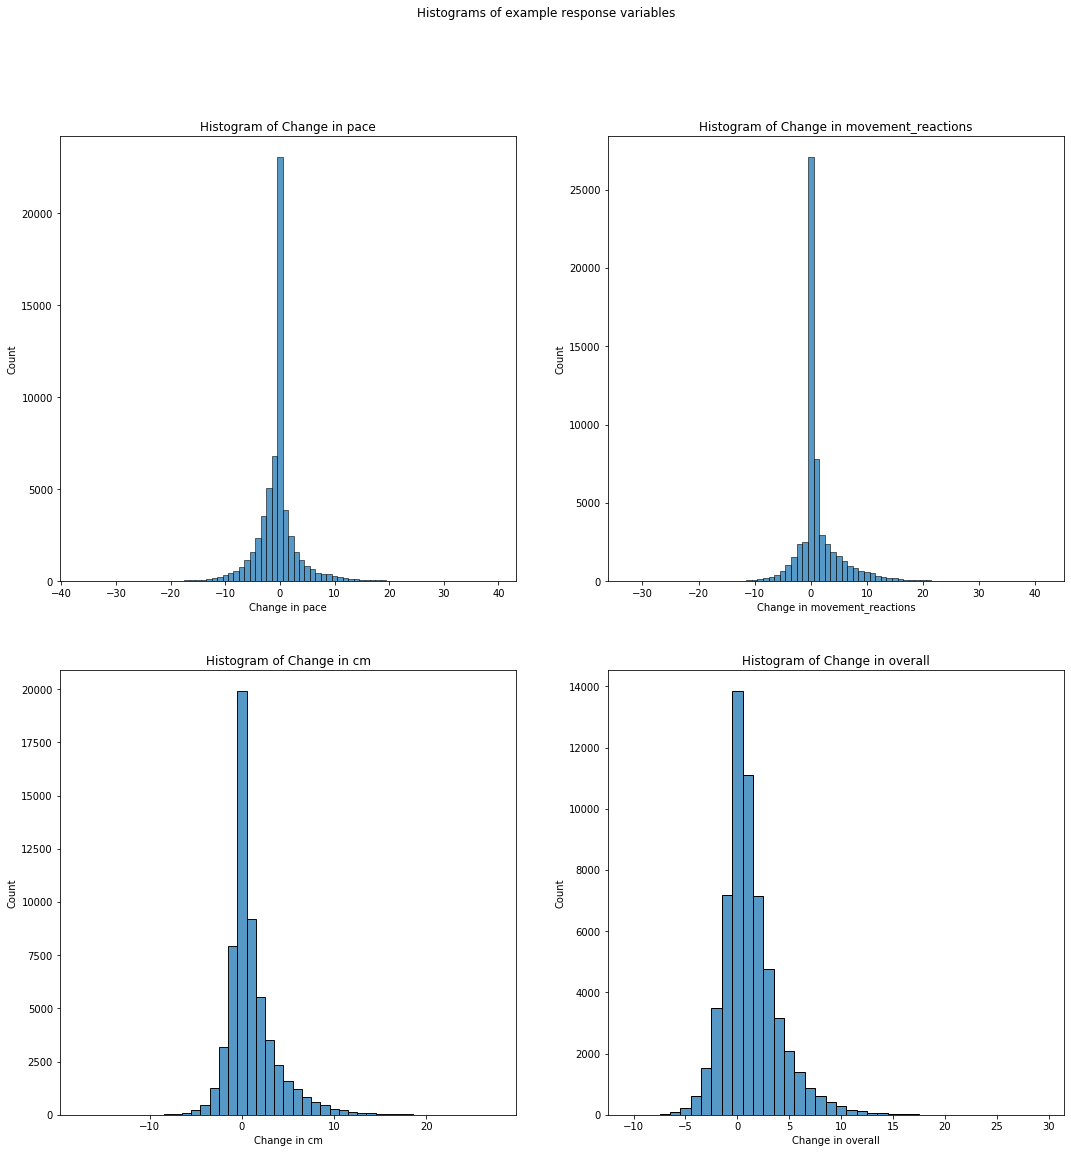

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
fig.suptitle("Histograms of example response variables")
fig.set_size_inches(18,18)
for i in range(len(examples)):
    
    cur_ax = axs[i//2][i%2]
    example = examples[i]
    
    sns.histplot(df[example], ax = cur_ax, discrete = True)
    cur_ax.set_title(f"Histogram of {example}")

This confirms our previous expectation that most things don't change from year to year. We can see that all of the plots center around 0. Now, let's look at scatter plots of changes of variables vs the original variables. 

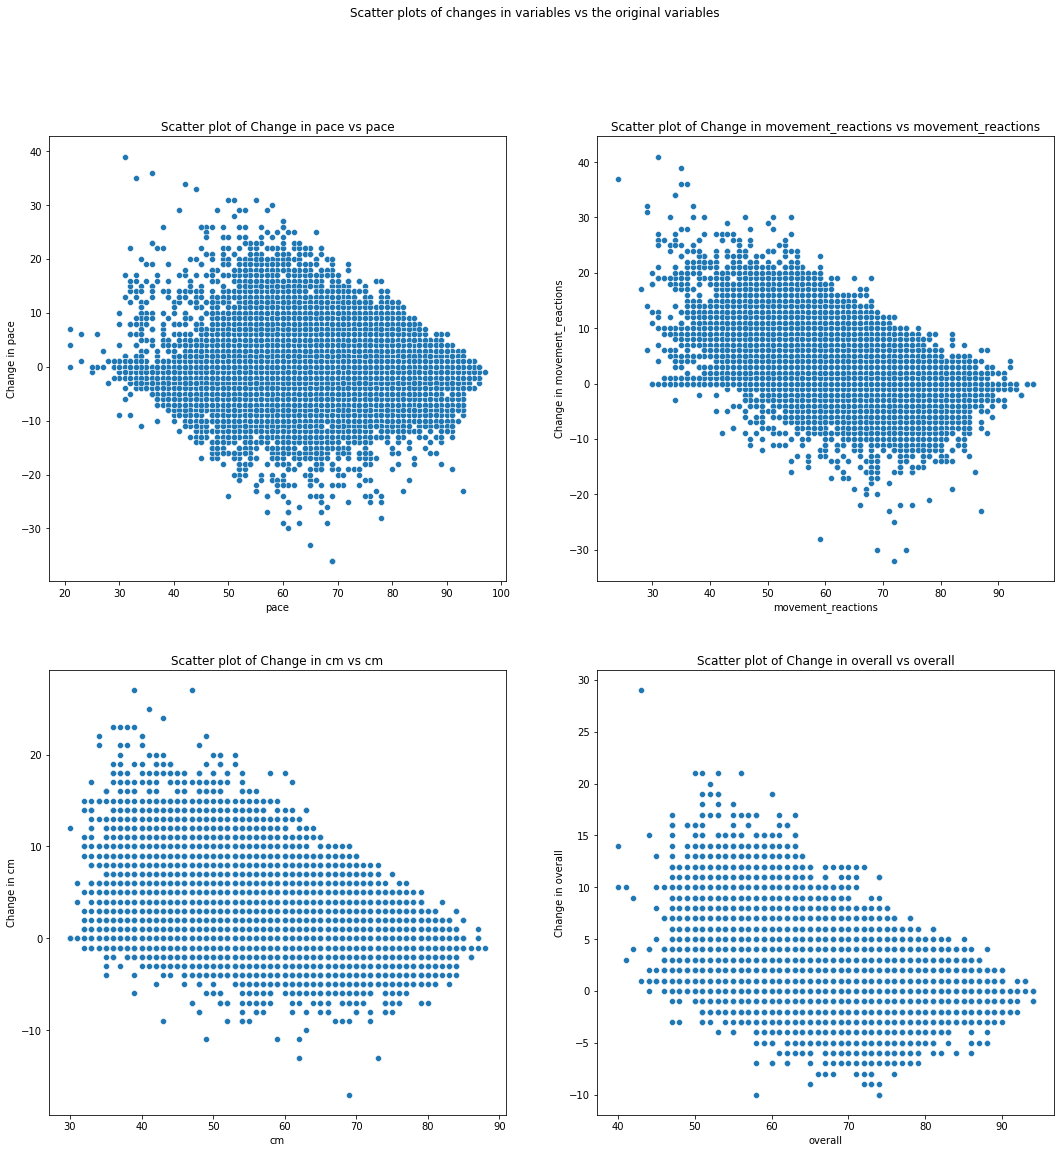

In [17]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
fig.suptitle("Scatter plots of changes in variables vs the original variables")
fig.set_size_inches(18,18)
for i in range(len(examples)):
    
    cur_ax = axs[i//2][i%2]
    example = examples[i]
    example_base = examples_base[i]
    
    sns.scatterplot(x = df[example_base], y = df[example], ax = cur_ax)    
    cur_ax.set_title(f"Scatter plot of {example} vs {example_base}")

These plots show that there isn't a clear relationship between a variable and its change. This is most obvious in the first group of response variables. This means that the full values of our response varialbes are not good predictors for the changes in these variables. Of course, these plots are not enough to confirm this, but they invite us to do feature selection when doing modeling. 

Let's now look at our other available pridictors, the variables in Group 2. Among those, age and potential sound like they could be good predictors. Remember that we're not storing full potential, but the difference between potential and overall score. Let's look at a scatter plot of our response variables vs these two predictors. 

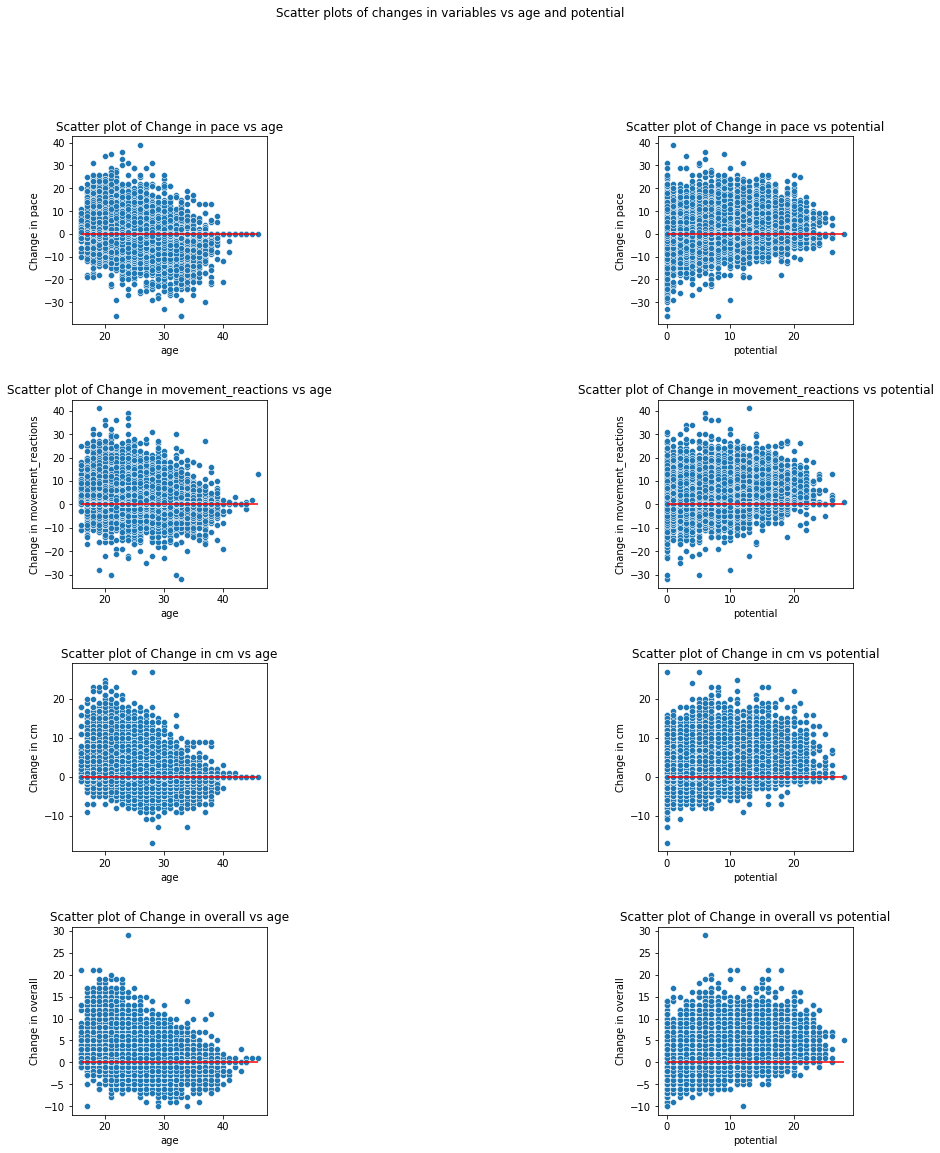

In [18]:
fig, axs = plt.subplots(nrows = 4, ncols = 2)
fig.suptitle("Scatter plots of changes in variables vs age and potential")
fig.set_size_inches(14,18)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=0.4)
for i in range(len(examples)):
    
    example = examples[i]
    
    # First plot:
    sns.scatterplot(x = df['age'], y = df[example], ax = axs[i][0])
    axs[i][0].set_title(f"Scatter plot of {example} vs age")
    axs[i][0].hlines(y=0, xmin = min(df['age']), xmax =  max(df['age']), color = "red")
    
    # Second plot:
    sns.scatterplot(x = df['potential'], y = df[example], ax = axs[i][1])
    axs[i][1].set_title(f"Scatter plot of {example} vs potential")
    axs[i][1].hlines(y=0, xmin = min(df['potential']), xmax =  max(df['potential']), color = "red")
    

In general, it looks like with higher potential difference and less age, players are more likely to increase in their statistics. It should be noted that it looks like there is a lot of noise in the data. 

# Modeling:

We will use the linear models (with their variations) as our main model. This is for two reason:
- Our response variables are all numerical, so this model is appropriate.
- We expect that the creators of the game use linear relationships between the variables to choose some of these variables. 

### Modeling Goal:
- Predict change in response variables using available predictors. 

### Splitting the Data:
We will split our data into train/val/test. The problem statement says that the test set should be players from Division 1 European Leangue (Top five Leagues). These teams change slightly from year to year and the data on which players are in which leagues is not directly available. To solve this, we will maually store which football clubs are in the top 5 leagues in 2020 and then split the players based on that list of clubs. 

In [17]:
clubs = [
    "Deportivo Alavés", "Athletic Club de Bilbao", "Atlético Madrid", "FC Barcelona", "Cádiz CF", "RC Celta", "SD Eibar", 
    "Elche CF", "Getafe CF", "Granada CF", "SD Huesca", "Levante UD", "CA Osasuna", "Real Betis", "Real Madrid", "Real Sociedad", 
    "Sevilla FC", "Valencia CF", "Real Valladolid CF", "Villarreal CF", "Dijon FCO", "RC Strasbourg Alsace", "Nîmes Olympique",
    "FC Lorient", "Stade de Reims", "AS Saint-Étienne", "FC Nantes", "Stade Brestois 29", "FC Girondins de Bordeaux", 
    "Racing Club de Lens", "FC Metz", "Angers SCO", "OGC Nice", "Montpellier HSC", "AS Monaco", "Olympique Lyonnais", 
    "Olympique de Marseille", "Stade Rennais FC", "LOSC Lille", "Paris Saint-Germain", "Arsenal", "Aston Villa", 
    "Brighton & Hove Albion", "Burnley", "Chelsea", "Crystal Palace", "Everton", "Fulham", "Leeds United", "Leicester City",
    "Liverpool", "Manchester City", "Manchester United", "Newcastle United", "Sheffield United", "Southampton", "Tottenham Hotspur",
    "West Bromwich Albion", "West Ham United", "Wolverhampton Wanderers", "Atalanta", "Benevento", "Bologna", "Cagliari", 
    "Crotone", "Fiorentina", "Genoa", "Hellas Verona", "Inter", "Juventus", "Lazio", "Milan", "Napoli", "Parma", "Roma", "Sampdoria",
    "Sassuolo", "Spezia", "Torino", "Udinese",
    "FC Bayern München", "Borussia Dortmund", "RB Leipzig", "Borussia Mönchengladbach", "Bayer 04 Leverkusen", "TSG 1899 Hoffenheim",
    "VfL Wolfsburg", "SC Freiburg", "Eintracht Frankfurt", "Hertha BSC", "1. FC Union Berlin", "FC Schalke 04", 
    "1. FSV Mainz 05", "1. FC Köln", "FC Augsburg", "SV Werder Bremen", "DSC Arminia Bielefeld", "VfB Stuttgart"
]

In [18]:
train_locations = [ x not in clubs for x in df['club'].values]
df_train_full = df.loc[train_locations]
df_train_full = df_train_full.drop("club", axis = 1)
display(df_train_full.head())

test_locations = [ x in clubs for x in df['club'].values]
df_test = df.loc[ test_locations ]
df_test = df_test.drop("club", axis = 1)
display(df_test.head())

,age,height_cm,overall,potential,loaned_from,contract_valid_until,pace,shooting,passing,dribbling,...,position_RCM,position_RDM,position_RES,position_RF,position_RM,position_RS,position_RW,position_RWB,position_ST,position_SUB
1,33,175,79,0,0,True,68.0,81.0,73.0,82.0,...,0,0,0,0,0,1,0,0,0,0
2,38,188,59,0,0,False,30.0,30.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,1
3,31,171,71,0,0,True,38.0,63.0,75.0,72.0,...,0,0,0,0,0,0,0,0,0,1
5,30,185,62,0,0,True,52.0,25.0,43.0,38.0,...,0,0,0,0,0,0,0,0,0,0
9,33,189,71,0,0,False,55.0,61.0,70.0,62.0,...,1,0,0,0,0,0,0,0,0,0


,age,height_cm,overall,potential,loaned_from,contract_valid_until,pace,shooting,passing,dribbling,...,position_RCM,position_RDM,position_RES,position_RF,position_RM,position_RS,position_RW,position_RWB,position_ST,position_SUB
0,32,181,68,0,0,True,71.0,59.0,66.0,66.0,...,0,0,0,0,0,0,0,0,0,0
4,41,194,76,0,0,False,30.0,30.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,1
6,38,191,71,0,0,False,30.0,30.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,0
7,33,185,74,0,0,False,43.0,48.0,54.0,52.0,...,0,0,0,0,0,0,0,0,0,1
8,36,191,82,0,0,False,30.0,30.0,30.0,30.0,...,0,0,0,0,0,0,0,0,0,0


Now, we split the train dataframe into train and validation sets. We will use 80% of our data for training and 20% for validation. We will also keep the full train dataframe in case we decide to do cross validations. 

In [19]:
df_train, df_val = train_test_split(df_train_full, train_size = 0.8, shuffle = True, random_state = 0)
print(df_train.shape)
print(df_val.shape)

(37717, 180)
(9430, 180)


### Selecting the Data:

To help in building our models, we can create a helper function to select the predictors and response variable.

In [20]:
def select_response(df, variable):
    # Choose the response variable:
    y = df.copy()[variable].values
    
    # Drop all other response variables:
    x = df.copy()
    x = x.drop(RG1, axis=1)
    x = x.drop(RG2, axis=1)
    x = x.drop(RG3, axis=1)
    x = x.drop(RG4, axis=1)
    return x, y
# Check:
x, y = select_response(df_train, "Change in pace")
print(y)
print(x.shape)

[  0. -13.   0. ...  -1.   0.  -6.]
(37717, 107)


### Baseline Model: Linear Regression

We will create a base model of a simple multi linear regression. This model is the simplist possible and we will use it to compare other models with it.

In [39]:
for i in range(len(groups)):
    group = groups[i]
    baseline_score_train_list = []
    baseline_score_val_list = []
    for variable in group:
        x_train, y_train = select_response(df_train, variable) 
        model = LinearRegression().fit(x_train, y_train)
        
        cur_train_score = model.score(x_train, y_train)
        baseline_score_train_list.append(cur_train_score)
        
        x_val, y_val = select_response(df_val, variable)
        cur_val_score = model.score(x_val, y_val)
        baseline_score_val_list.append(cur_val_score)
        
    print(f"The train r2 score of the baseline model on response group {i+1} is {np.mean(baseline_score_train_list):0.4F}")
    print(f"The validation r2 score of the baseline model on response group {i+1} is {np.mean(baseline_score_val_list):0.4F}")
    print("")

The train r2 score of the baseline model on response group 1 is 0.1493
The validation r2 score of the baseline model on response group 1 is 0.1447

The train r2 score of the baseline model on response group 2 is 0.1707
The validation r2 score of the baseline model on response group 2 is 0.1441

The train r2 score of the baseline model on response group 3 is 0.2343
The validation r2 score of the baseline model on response group 3 is 0.2321

The train r2 score of the baseline model on response group 4 is 0.2544
The validation r2 score of the baseline model on response group 4 is 0.2481



The scores of the baseline model look resonable. Our goal now is to improve on them. 

### Polynomial Regression:


We can see that the score using linear regression is low even on the train data, so, we can try using stronger models. Our first approach is using polynomial features. We want to choose a large degree, even if that overfits, and then look into regularizing that. Let's try using a degree of 10.

In [91]:
warnings.filterwarnings("ignore")
for i in range(len(groups)):
    group = groups[i]
    poly_score_train_list = []
    poly_score_val_list = []
    for variable in group:
        x_train, y_train = select_response(df_train, variable)
        #x_train = x_train.values
        x_train_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x_train[col].values.reshape(-1, 1)) for col in x_train.columns ))
        data_transormer = StandardScaler().fit(x_train_poly)
        x_train_poly = data_transormer.transform(x_train_poly)
        model = LinearRegression().fit(x_train_poly, y_train)
        
        cur_train_score = model.score(x_train_poly, y_train)
        # print(cur_train_score)
        poly_score_train_list.append(cur_train_score)
        
        x_val, y_val = select_response(df_val, variable)
        x_val_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x_val[col].values.reshape(-1, 1)) for col in x_train.columns )) 
        x_val_poly = data_transormer.transform(x_val_poly)
        cur_val_score = model.score(x_val_poly, y_val)
        poly_score_val_list.append(cur_val_score)
        
    print(f"The train r2 score of the polynomial model on response group {i+1} is {np.mean(poly_score_train_list):0.4F}")
    print(f"The validation r2 score of the polynomial model on response group {i+1} is {np.mean(poly_score_val_list):0.4F}")
    print("")
warnings.filterwarnings("default")

The train r2 score of the polynomial model on response group 1 is 0.1824
The validation r2 score of the polynomial model on response group 1 is 0.1399

The train r2 score of the polynomial model on response group 2 is 0.2659
The validation r2 score of the polynomial model on response group 2 is 0.1721

The train r2 score of the polynomial model on response group 3 is 0.2692
The validation r2 score of the polynomial model on response group 3 is 0.2226

The train r2 score of the polynomial model on response group 4 is 0.2879
The validation r2 score of the polynomial model on response group 4 is 0.2499



### Regularization:

Now, that we have a model that overfits, we can look at regularizing using an L1 or L2 loss. Because we have a lot of models to train, we will only try using L2, as it has a closed form solution. 

Because we have a lot of models to train, we can't do a cross validation for choosing the constant for every model. Instead, we will do cross validation for our example response variables, and choose the same constant for all the group of variables. Although this is not ideal, but we expect it will still preform well. 

In [23]:
warnings.filterwarnings("ignore")
# Finding the constants for every example:
best_alphas = []
for i in range(len(examples)):
    ex_variable = examples[i]
    # Select the data from the full train df:
    x, y = select_response(df_train_full, ex_variable)
    x_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x[col].values.reshape(-1, 1)) 
                        for col in x.columns ))
    data_transormer = StandardScaler().fit(x_poly)
    x_poly = data_transormer.transform(x_poly)
    
    # Cross Validation:
    possible_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
    cv_errors = []
    for alpha in possible_alphas:
        model = Ridge(alpha = alpha, max_iter=5000, random_state=109)
        cur_cv_error = cross_val_score(model, x_poly, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
        cv_errors.append( np.mean(-cur_cv_error) )
    best_error = min(cv_errors)
    pos = cv_errors.index(best_error)
    cur_best_alpha = possible_alphas[pos]
    best_alphas.append(cur_best_alpha)
    print(f"The chosen alpha for the group {i+1} is {cur_best_alpha} with an MSE score of {best_error:0.4F}")
warnings.filterwarnings("default")

The chosen alpha for the group 1 is 10.0 with an MSE score of 13.7400
The chosen alpha for the group 2 is 10.0 with an MSE score of 12.3922
The chosen alpha for the group 3 is 10.0 with an MSE score of 5.8761
The chosen alpha for the group 4 is 100.0 with an MSE score of 5.3945


Now that we have our chosen constants, we can train the models for all the response variables. Because this is the final model we will train in linear regression, we will train on all the train data and find the accuracy on the test data. 

In [113]:
warnings.filterwarnings("ignore")
for i in range(len(groups)):
    group = groups[i]
    alpha = best_alphas[i]
    ridge_score_train_list = []
    ridge_score_test_list = []
    for variable in group:
        x_train, y_train = select_response(df_train_full, variable)
        x_train_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x_train[col].values.reshape(-1, 1)) for col in x_train.columns ))
        data_transormer = StandardScaler().fit(x_train_poly)
        x_train_poly = data_transormer.transform(x_train_poly)
        model = Ridge(alpha = alpha, max_iter=5000, random_state=109).fit(x_train_poly, y_train)
        
        cur_train_score = model.score(x_train_poly, y_train)
        # print(cur_train_score)
        ridge_score_train_list.append(cur_train_score)
        
        x_test, y_test = select_response(df_test, variable)
        x_test_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x_test[col].values.reshape(-1, 1)) for col in x_train.columns )) 
        x_test_poly = data_transormer.transform(x_test_poly)
        cur_test_score = model.score(x_test_poly, y_test)
        ridge_score_test_list.append(cur_test_score)
        
    print(f"The train r2 score of the ridge model on response group {i+1} is {np.mean(ridge_score_train_list):0.4F}")
    print(f"The test r2 score of the ridge model on response group {i+1} is {np.mean(ridge_score_test_list):0.4F}")
    print("")
warnings.filterwarnings("default")

The train r2 score of the ridge model on response group 1 is 0.1705
The test r2 score of the ridge model on response group 1 is 0.1399

The train r2 score of the ridge model on response group 2 is 0.2422
The test r2 score of the ridge model on response group 2 is 0.1645

The train r2 score of the ridge model on response group 3 is 0.2584
The test r2 score of the ridge model on response group 3 is 0.2116

The train r2 score of the ridge model on response group 4 is 0.2721
The test r2 score of the ridge model on response group 4 is 0.2015



So far, we've only been looking at the mean score for each group. Now, let's look at one group and observe the distribution of its scores using the Ridge Regression. We will look at group 2, as it has the most number of variables. 

In [49]:
warnings.filterwarnings("ignore")
group = groups[1]
alpha = best_alphas[1]
ridge_score_train_list = []
ridge_score_test_list = []
for variable in group:
    x_train, y_train = select_response(df_train_full, variable)
    x_train_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x_train[col].values.reshape(-1, 1)) for col in x_train.columns ))
    data_transormer = StandardScaler().fit(x_train_poly)
    x_train_poly = data_transormer.transform(x_train_poly)
    model = Ridge(alpha = alpha, max_iter=5000, random_state=109).fit(x_train_poly, y_train)

    cur_train_score = model.score(x_train_poly, y_train)
    # print(cur_train_score)
    ridge_score_train_list.append(cur_train_score)

    x_test, y_test = select_response(df_test, variable)
    x_test_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(x_test[col].values.reshape(-1, 1)) for col in x_train.columns )) 
    x_test_poly = data_transormer.transform(x_test_poly)
    cur_test_score = model.score(x_test_poly, y_test)
    ridge_score_test_list.append(cur_test_score)
warnings.filterwarnings("default")

The variance of the scores for response group 2 is 0.0212


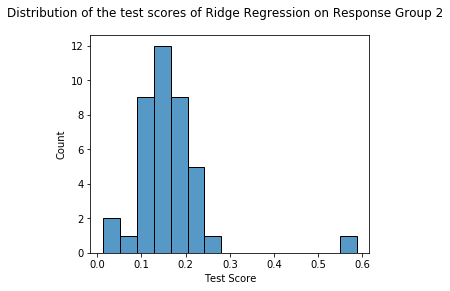

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(5,4)
fig.suptitle("Distribution of the test scores of Ridge Regression on Response Group 2")
sns.histplot(ridge_score_test_list, bins= 15, ax=ax)
ax.set_xlabel("Test Score")
print(f"The variance of the scores for response group 2 is {np.var(ridge_score_train_list):0.4F}")

We can see that the scores are distributed around their mean, with one outlier having a huge score, and with a variance of 0.0212. Let's find which variable is the outlier and let's find the variance of the scores without the outlier.

In [111]:
ind = list(np.asarray(ridge_score_test_list)>0.5).index(True)
print(f"The variable with a huge R2 score is \"{groups[1][ind]}\"")
temp = []
for x in ridge_score_test_list:
    if x>0.5:
        continue
    temp.append(x)
print(f"The variance of the scores for response group 2 after removing the outlier is {np.var(temp):0.4F}")

The variable with a huge R2 score is "Change in mentality_composure"
The variance of the scores for response group 2 after removing the outlier is 0.0028


So, it looks like mentality composure is easier to predict. In addition, the variance of the scores without it is 0.0028, which shows that the Ridge model performs somewhat similarly on the variables of this group. 

### More Complex Models:

We can see that the model still doesn't perform well on the train or the test data. This suggests that, if there is a more accurate relationship between the inputs and outputs, that it is a more complex relationship. So, we now explore more complex models for this problem. Because these models are computationally intensive, we can't train them on every reponse variable. From now on in this notebook, we will only work with our four examples. 

### Neural Networks:

We now try to fit a Feed-forward Neural Net to our data. Note that we used that train and validation set to choose the hyper parameters for the nets. But to get the accuracy of the nets, we will train the nets on all the data and report tha R2 score on the test data. 

In [167]:
for i in range(len(examples)):
    ex_variable = examples[i]

    # Select the data and transform it:
    x_train, y_train = select_response(df_train_full, ex_variable)
    x_train = x_train.values
    data_transormer = StandardScaler().fit(x_train)
    x_train = data_transormer.transform(x_train)

    # Create the model:
    NN_model = tf.keras.Sequential()

    # Create the hidden layers:
    NN_model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(x_train.shape[1],),
                                          kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
    NN_model.add(tf.keras.layers.Dense(100, activation='relu',
                                          kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
    NN_model.add(tf.keras.layers.Dense(100, activation='relu', 
                                          kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))

    # Add a dropout regularizer:
    NN_model.add(tf.keras.layers.Dropout(0.5))

    # Create the output layer:
    NN_model.add(tf.keras.layers.Dense(1, activation='linear'))

    # Compile it and run it
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    NN_model.compile(optimizer=optimizer,loss="mean_squared_error",metrics = ['accuracy'])
    NN_history = NN_model.fit(x_train, y_train, epochs=1500, verbose=0, validation_split=0.2, batch_size=1024,
                                   callbacks=callback, shuffle=True)
    
    # Report the score on the train data:
    y_pred_train = NN_model.predict(x_train)
    cur_train_score = r2_score(y_train, y_pred_train)
    print(f"The train r2 score of the NN model on the example from response group {i+1} is {cur_train_score:0.4F}")
    
    # Report the score on the test data:
    x_test, y_test = select_response(df_test,ex_variable)
    x_test = x_test.values
    x_test = data_transormer.transform(x_test)
    y_pred = NN_model.predict(x_test)
    cur_test_score = r2_score(y_test, y_pred)
    print(f"The test r2 score of the NN model on the example from response group {i+1} is {cur_test_score:0.4F}")

Epoch 00058: early stopping
The train r2 score of the NN model on the example from response group 1 is 0.1735
The test r2 score of the NN model on the example from response group 1 is 0.1551
Epoch 00062: early stopping
The train r2 score of the NN model on the example from response group 2 is 0.2482
The test r2 score of the NN model on the example from response group 2 is 0.1901
Epoch 00020: early stopping
The train r2 score of the NN model on the example from response group 3 is 0.2446
The test r2 score of the NN model on the example from response group 3 is 0.1814
Epoch 00071: early stopping
The train r2 score of the NN model on the example from response group 4 is 0.2857
The test r2 score of the NN model on the example from response group 4 is 0.1992


We can see some improvement in the first two groups. However, it is hard to show for sure that there is an improvement, as the previous scores we have are for the whole groups, not just the examples. 

### Categorical Changes:

We've seen that it is hard to get good accuracies when predicting exact changes. Instead, we can try to create categories of changes and predict them. For example, for every change in a skill, we can create three categories:
- There is a positive change in the skill. 2
- There is no change in the skill. 1
- There is a negative change in the skill. 0

Let's create models to predict these categories. We will start with a simple logistical regression, then we will add polynomial terms and regularuzation.

### Logistical Regression:

We will create a simple logistical regression model for each skill.

In [187]:
for i in range(len(groups)):
    group = groups[i]
    baseline_accuracy_train_list = []
    baseline_accuracy_val_list = []
    for variable in group:
        x_train, y_train = select_response(df_train, variable)
        data_transformer = StandardScaler().fit(x_train)
        x_train = data_transformer.transform(x_train)
        y_train[ y_train>0 ] = 2
        y_train[ y_train==0 ] = 1
        y_train[ y_train<0 ] = 0
        model = LogisticRegression(penalty='none', max_iter=1500, random_state=109, multi_class='ovr').fit(x_train, y_train)
        
        cur_train_accuracy = model.score(x_train, y_train)
        baseline_accuracy_train_list.append(cur_train_accuracy)
        
        x_val, y_val = select_response(df_val, variable)
        x_val = data_transformer.transform(x_val)
        y_val[ y_val>0 ] = 2
        y_val[ y_val==0 ] = 1
        y_val[ y_val<0 ] = 0
        cur_val_accuracy = model.score(x_val, y_val)
        baseline_accuracy_val_list.append(cur_val_accuracy)
    print(f"The train accuracy of the logistical model on response group {i+1} is {np.mean(baseline_accuracy_train_list):0.4F}")
    print(f"The validation accuracy of the logistical model on response group {i+1} is {np.mean(baseline_accuracy_val_list):0.4F}")
    print("")

The train accuracy of the logistical model on response group 1 is 0.5898
The validation accuracy of the logistical model on response group 1 is 0.5869

The train accuracy of the logistical model on response group 2 is 0.7348
The validation accuracy of the logistical model on response group 2 is 0.7299

The train accuracy of the logistical model on response group 3 is 0.6258
The validation accuracy of the logistical model on response group 3 is 0.6238

The train accuracy of the logistical model on response group 4 is 0.5995
The validation accuracy of the logistical model on response group 4 is 0.5935



We can see that we get good accuracies from this. Let's try to improve it more. 

### Logistic Regression with Polynomial Terms:

As with the linear regression, we will use a high degree and then regularize. 

In [18]:
warnings.filterwarnings("ignore")
for i in range(len(groups)):
    group = groups[i]
    poly_accuracy_train_list = []
    poly_accuracy_val_list = []
    for variable in group:
        x_train, y_train = select_response(df_train, variable)
        x_train_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(
                                                                    x_train[col].values.reshape(-1, 1)) 
                                                                    for col in x_train.columns ))
        data_transformer = StandardScaler().fit(x_train_poly)
        x_train_poly = data_transformer.transform(x_train_poly)
        y_train[ y_train>0 ] = 2
        y_train[ y_train==0 ] = 1
        y_train[ y_train<0 ] = 0
        model = LogisticRegression(penalty='none', max_iter=1500, random_state=109, multi_class='ovr').fit(x_train_poly, y_train)
        
        cur_train_accuracy = model.score(x_train_poly, y_train)
        poly_accuracy_train_list.append(cur_train_accuracy)
        
        x_val, y_val = select_response(df_val, variable)
        x_val_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(
                                                                    x_val[col].values.reshape(-1, 1)) 
                                                                    for col in x_train.columns ))
        x_val_poly = data_transformer.transform(x_val_poly)
        y_val[ y_val>0 ] = 2
        y_val[ y_val==0 ] = 1
        y_val[ y_val<0 ] = 0
        cur_val_accuracy = model.score(x_val_poly, y_val)
        poly_accuracy_val_list.append(cur_val_accuracy)
    print(f"The train accuracy of the logistical model with polynomial fratures on response group {i+1} is {np.mean(poly_accuracy_train_list):0.4F}")
    print(f"The validation accuracy of the logistical model with polynomial fratures on response group {i+1} is {np.mean(poly_accuracy_val_list):0.4F}")
    print("")
warnings.filterwarnings("default")

The train accuracy of the logistical model with polynomial fratures on response group 1 is 0.6020
The validation accuracy of the logistical model with polynomial fratures on response group 1 is 0.5930

The train accuracy of the logistical model with polynomial fratures on response group 2 is 0.7434
The validation accuracy of the logistical model with polynomial fratures on response group 2 is 0.7345

The train accuracy of the logistical model with polynomial fratures on response group 3 is 0.6331
The validation accuracy of the logistical model with polynomial fratures on response group 3 is 0.6255

The train accuracy of the logistical model with polynomial fratures on response group 4 is 0.6110
The validation accuracy of the logistical model with polynomial fratures on response group 4 is 0.6000



### Regularization:

We will regularize with a penalty of L2. First, we will use the example variables to choose the regularization constant, then, we will use that constant for all the group. 

In [2]:
warnings.filterwarnings("ignore")
# Finding the constants for every example:
best_Cs = []
for i in range(3,4):#len(examples)):
    ex_variable = examples[i]
    # Select the data from the full train df:
    x, y = select_response(df_train_full, ex_variable)
    x_poly = np.hstack(( PolynomialFeatures(degree=5, include_bias=False).fit_transform(x[col].values.reshape(-1, 1)) 
                        for col in x.columns ))
    data_transormer = StandardScaler().fit(x_poly)
    x_poly = data_transormer.transform(x_poly)
    y[ y>0  ] = 2
    y[ y==0 ] = 1
    y[ y<0  ] = 0
    # Cross Validation:
    possible_Cs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
    cv_accuracies = []
    for C in possible_Cs:
        model = LogisticRegression(penalty='l2', C=C, max_iter=1500, random_state=109, multi_class='ovr')
        #print("test1")
        cur_cv_accuracy = cross_val_score(model, x_poly, y, cv=3, scoring="accuracy", verbose=1, n_jobs=3)
        #print("test2")
        cv_accuracies.append( np.mean(cur_cv_accuracy) )
    best_accuracy = max(cv_accuracies)
    pos = cv_accuracies.index(best_accuracy)
    cur_best_C = possible_Cs[pos]
    best_Cs.append(cur_best_C)
    print(f"The chosen C values for the group {i+1} is {cur_best_C} with an accuracy of {best_accuracy:0.4F}")
warnings.filterwarnings("default")

The chosen C values for the group 1 is 0.0001 with an accuracy of 0.5700
The chosen C values for the group 2 is 0.0001 with an accuracy of 0.6662
The chosen C values for the group 3 is 0.001 with an accuracy of 0.6125
The chosen C values for the group 4 is 0.0001 with an accuracy of 0.5906


Now that we have our constants, we can train on all the variables.

In [37]:
warnings.filterwarnings("ignore")
for i in range(len(groups)):
    group = groups[i]
    C = best_Cs[i]
    ridge_accuracy_train_list = []
    ridge_accuracy_val_list = []
    for variable in group:
        x_train, y_train = select_response(df_train, variable)
        x_train_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(
                                                                    x_train[col].values.reshape(-1, 1)) 
                                                                    for col in x_train.columns ))
        data_transformer = StandardScaler().fit(x_train_poly)
        x_train_poly = data_transformer.transform(x_train_poly)
        y_train[ y_train>0 ] = 2
        y_train[ y_train==0 ] = 1
        y_train[ y_train<0 ] = 0
        model = LogisticRegression(penalty='l2', max_iter=1500, random_state=109, 
                                   multi_class='ovr', C=C).fit(x_train_poly, y_train)
        
        cur_train_accuracy = model.score(x_train_poly, y_train)
        ridge_accuracy_train_list.append(cur_train_accuracy)
        
        x_val, y_val = select_response(df_val, variable)
        x_val_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(
                                                                    x_val[col].values.reshape(-1, 1)) 
                                                                    for col in x_train.columns ))
        x_val_poly = data_transformer.transform(x_val_poly)
        y_val[ y_val>0 ] = 2
        y_val[ y_val==0 ] = 1
        y_val[ y_val<0 ] = 0
        cur_val_accuracy = model.score(x_val_poly, y_val)
        ridge_accuracy_val_list.append(cur_val_accuracy)
    print(f"The train accuracy of the Ridge classifier on response group {i+1} is {np.mean(ridge_accuracy_train_list):0.4F}")
    print(f"The validation accuracy of the Ridge classifier on response group {i+1} is {np.mean(ridge_accuracy_val_list):0.4F}")
    print("")
warnings.filterwarnings("default")

The train accuracy of the Ridge classifier on response group 1 is 0.5741
The validation accuracy of the Ridge classifier on response group 1 is 0.5723

The train accuracy of the Ridge classifier on response group 2 is 0.6798
The validation accuracy of the Ridge classifier on response group 2 is 0.6760

The train accuracy of the Ridge classifier on response group 3 is 0.6158
The validation accuracy of the Ridge classifier on response group 3 is 0.6137

The train accuracy of the Ridge classifier on response group 4 is 0.5926
The validation accuracy of the Ridge classifier on response group 4 is 0.5908



### Accuracy on the Test Data:

We can see that the polynomial model alone performs better than the model with regularization. So, let's check how this model performs on the Test data.

In [38]:
warnings.filterwarnings("ignore")
for i in range(len(groups)):
    group = groups[i]
    poly_accuracy_train_list = []
    poly_accuracy_test_list = []
    for variable in group:
        x_train, y_train = select_response(df_train_full, variable)
        x_train_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(
                                                                    x_train[col].values.reshape(-1, 1)) 
                                                                    for col in x_train.columns ))
        data_transformer = StandardScaler().fit(x_train_poly)
        x_train_poly = data_transformer.transform(x_train_poly)
        y_train[ y_train>0 ] = 2
        y_train[ y_train==0 ] = 1
        y_train[ y_train<0 ] = 0
        model = LogisticRegression(penalty='none', max_iter=1500, random_state=109, multi_class='ovr').fit(x_train_poly, y_train)
        
        cur_train_accuracy = model.score(x_train_poly, y_train)
        poly_accuracy_train_list.append(cur_train_accuracy)
        
        x_test, y_test = select_response(df_test, variable)
        x_test_poly = np.hstack(( PolynomialFeatures(degree=10, include_bias=False).fit_transform(
                                                                    x_test[col].values.reshape(-1, 1)) 
                                                                    for col in x_train.columns ))
        x_test_poly = data_transformer.transform(x_test_poly)
        y_test[ y_test>0 ] = 2
        y_test[ y_test==0 ] = 1
        y_test[ y_test<0 ] = 0
        cur_test_accuracy = model.score(x_test_poly, y_test)
        poly_accuracy_test_list.append(cur_test_accuracy)
    print(f"The train accuracy of the logistical model with polynomial fratures on response group {i+1} is {np.mean(poly_accuracy_train_list):0.4F}")
    print(f"The test accuracy of the logistical model with polynomial fratures on response group {i+1} is {np.mean(poly_accuracy_test_list):0.4F}")
    print("")
warnings.filterwarnings("default")

The train accuracy of the logistical model with polynomial fratures on response group 1 is 0.6011
The test accuracy of the logistical model with polynomial fratures on response group 1 is 0.5684

The train accuracy of the logistical model with polynomial fratures on response group 2 is 0.7421
The test accuracy of the logistical model with polynomial fratures on response group 2 is 0.7053

The train accuracy of the logistical model with polynomial fratures on response group 3 is 0.6321
The test accuracy of the logistical model with polynomial fratures on response group 3 is 0.6021

The train accuracy of the logistical model with polynomial fratures on response group 4 is 0.6088
The test accuracy of the logistical model with polynomial fratures on response group 4 is 0.5638



Now that we have the validation scores and accuracies for each model, let's display that to compare it.

In [43]:
data_regression = {
'Linear Regression':[0.1447, 0.1441, 0.2343,0.2544],
'Polynomial Regression': [0.1399, 0.1721, 0.2226, 0.2499],
'Ridge Regression':[0.1399, 0.1645, 0.2116, 0.2015],
'Neural Network Regression':[0.1551, 0.1901, 0.1814, 0.1992]
}

data_classification= {
'Logistical Regression':[0.5869, 0.7299, 0.6238, 0.5935],
'Logistical Regression with polynomial terms':[0.5930, 0.7345, 0.6255, 0.6000],
'Ridge Classifier':[0.5723, 0.6760, 0.6137, 0.5908]
}

group_names = ['Basic Skills', 'Specific Skills', 'Position Ratings', 'Change in overall']

df_regression = pd.DataFrame(data_regression, index=group_names)
display(df_regression)

df_classification = pd.DataFrame(data_classification, index=group_names)
display(df_classification)

,Linear Regression,Polynomial Regression,Ridge Regression,Neural Network Regression
Basic Skills,0.1447,0.1399,0.1399,0.1551
Specific Skills,0.1441,0.1721,0.1645,0.1901
Position Ratings,0.2343,0.2226,0.2116,0.1814
Change in overall,0.2544,0.2499,0.2015,0.1992


,Logistical Regression,Logistical Regression with polynomial terms,Ridge Classifier
Basic Skills,0.5869,0.5930,0.5723
Specific Skills,0.7299,0.7345,0.6760
Position Ratings,0.6238,0.6255,0.6137
Change in overall,0.5935,0.6000,0.5908


# Conclusions:

For exact changes, we have achieved models that explain around 15% to 20% of the variability in the reponse variables. For categorical changes, we achieved models that have an accuracy of around 60%. We think it is hard to achieve better scores than these. This problem deals with changes year after year. We are using data from the game to predict the changes in the performance of the actual real players, and then to predict how the game will record these changes. So, this data might not be enough for very accurate predictions for real players. Some of the most influential factors in the developement and decline of players are the number of minutes played in a season and how many injuries did the player suffer (Or for how long they were injured). We expect that we will need such data in order to improve our scores more. However, we will believe that our scores are good enough and might be helpful to predict future changes for players. 